# <center>Diabetic Retinopathy Detection using PyTorch<center>

## Import Libraries

In [1]:
import pandas as pd #For reading csv files.
import numpy as np 
import matplotlib.pyplot as plt #For plotting.

import PIL.Image as Image #For working with image files.

#Importing torch
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader #For working with data.

from torchvision import models,transforms #For pretrained models,image transformations.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device) 

cpu


## EDA

Data Source: https://www.kaggle.com/c/aptos2019-blindness-detection/data.

In [3]:
# path = "/kaggle/input/aptos2019-blindness-detection/"

train_df = pd.read_csv("train.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    3662 non-null   object
 1   diagnosis  3662 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.3+ KB


In [4]:
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [5]:
train_df['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

Dataset description from Kaggle

A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale:

0 - No DR

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR

In [6]:
test_df = pd.read_csv('test.csv')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1928 entries, 0 to 1927
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id_code  1928 non-null   object
dtypes: object(1)
memory usage: 15.2+ KB


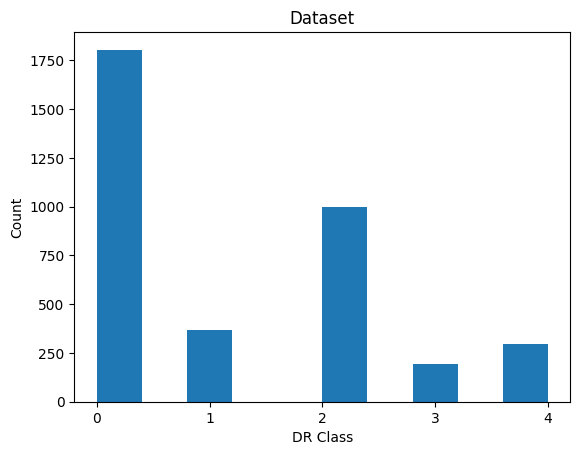

In [8]:
#Histogram of label counts.
train_df.diagnosis.hist()
plt.xticks([0,1,2,3,4])
plt.xlabel('DR Class')
plt.ylabel('Count')
plt.title('Dataset')
plt.grid(False)
plt.show() 

The data is imbalanced.
So we've to calculate weights for each class, which can be used in calculating loss.

In [9]:
from sklearn.utils import class_weight #For calculating weights for each class.
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df['diagnosis'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)
 
print(class_weights) #Prints the calculated weights for the classes.

c:\Users\UCCC\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


tensor([0.4058, 1.9795, 0.7331, 3.7948, 2.4827])


C:\Users\UCCC\AppData\Local\Temp\ipykernel_38444\3748449779.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  num = int(np.random.randint(0,len(train_df)-1,(1,))) #Picks a random number.


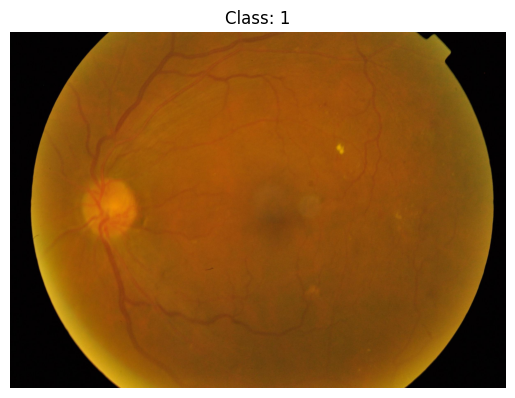

In [10]:
#For getting a random image from our training set.
num = int(np.random.randint(0,len(train_df)-1,(1,))) #Picks a random number.
sample_image = (f'train_images/{train_df["id_code"][num]}.png')#Image file.
sample_image = Image.open(sample_image) 
plt.imshow(sample_image)
plt.axis('off')
plt.title(f'Class: {train_df["diagnosis"][num]}') #Class of the random image.
plt.show()

## Preprocess the Data

In [ ]:
class dataset(Dataset): 
    '''
    dataset class overloads the __init__, __len__, __getitem__ methods of the Dataset class. 
    
    Attributes :
        df:  DataFrame object for the csv file.
        data_path: Location of the dataset.
        image_transform: Transformations to apply to the image.
        train: A boolean indicating whether it is a training_set or not.
    '''
    
    def __init__(self,df,data_path,image_transform=None,train=True): 
        super(Dataset,self).__init__() 
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train
        
    def __len__(self):
        return len(self.df) 
    
    def __getitem__(self,index):
        image_id = self.df['id_code'][index]
        image = Image.open(f'{self.data_path}/{image_id}.png') #Image.
        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.
        
        if self.train :
            label = self.df['diagnosis'][index] #Label.
            return image,label 
        
        else:
            return image            

In [12]:
image_transform = transforms.Compose([transforms.Resize([512,512]),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 
data_set = dataset(train_df,'train_images',image_transform=image_transform)

#Split the data_set so that valid_set. 
train_set,valid_set = torch.utils.data.random_split(data_set,[3302,360])

In [13]:
train_dataloader = DataLoader(train_set,batch_size=32,shuffle=True) #DataLoader for train_set.
valid_dataloader = DataLoader(valid_set,batch_size=32,shuffle=False) #DataLoader for validation_set.

## Build the Model

In [14]:
#Since we've less data, we'll use Transfer learning.
model = models.resnet34(pretrained=True) #Downloads the resnet18 model which is pretrained on Imagenet dataset.

c:\Users\UCCC\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\UCCC\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
#Replace the Final layer of pretrained resnet18 with 4 new layers.
model.fc = nn.Sequential(
    nn.Linear(512, 256),  # Layer 1: Input 512 → Output 256
    nn.Linear(256, 128),  # Layer 2: Input 256 → Output 128
    nn.Linear(128, 64),   # Layer 3: Input 128 → Output 64
    nn.Linear(64, 5)      # Layer 4: Input 64 → Output 5 (Final Output Layer)
)

In [16]:
model = model.to(device) #Moves the model to the device.

## Create functions for Training & Validation

In [18]:
def train(dataloader,model,loss_fn,optimizer):
    '''
    train function updates the weights of the model based on the
    loss using the optimizer in order to get a lower loss.
    
    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
         optimizer: Updates the model weights.
         
    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.train() #Sets the model for training.
    
    total = 0
    correct = 0
    running_loss = 0
    
    for batch,(x,y) in enumerate(dataloader): #Iterates through the batches.
        
        output = model(x.to(device)) #model's predictions.
        loss   = loss_fn(output,y.to(device)) #loss calculation.
       
        running_loss += loss.item()
        
        total        += y.size(0)
        predictions   = output.argmax(dim=1).cpu().detach() #Index for the highest score for all the samples in the batch.
        correct      += (predictions == y.cpu().detach()).sum().item() #No.of.cases where model's predictions are equal to the label.
        
        optimizer.zero_grad() #Gradient values are set to zero.
        loss.backward() #Calculates the gradients.
        optimizer.step() #Updates the model weights.
             
    
    avg_loss = running_loss/len(dataloader) # Average loss for a single batch
    
    print(f'\nTraining Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss

In [19]:
def validate(dataloader,model,loss_fn):
    '''
    validate function calculates the average loss per batch and the accuracy of the model's predictions.
    
    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
    
    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''
    
    model.eval() #Sets the model for evaluation.
    
    total = 0
    correct = 0
    running_loss = 0
    
    with torch.no_grad(): #No need to calculate the gradients.
        
        for x,y in dataloader:
            
            output        = model(x.to(device)) #model's output.
            loss          = loss_fn(output,y.to(device)).item() #loss calculation.
            running_loss += loss
            
            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            
    avg_loss = running_loss/len(dataloader) #Average loss per batch.      
    
    print(f'\nValidation Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss

## Optimize the Model

In [20]:
def optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs):
    '''
    optimize function calls the train & validate functions for (nb_epochs) times.
    
    Args :
        train_dataloader: DataLoader for the train_set.
        valid_dataloader: DataLoader for the valid_set.
        model: Given an input produces an output by multiplying the input with the model weights.
        loss_fn: Calculates the discrepancy between the label & the model's predictions.
        optimizer: Updates the model weights.
        nb_epochs: Number of epochs.
        
    Returns :
        Tuple of lists containing losses for all the epochs.
    '''
    #Lists to store losses for all the epochs.
    train_losses = []
    valid_losses = []

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        train_loss = train(train_dataloader,model,loss_fn,optimizer) #Calls the train function.
        train_losses.append(train_loss)
        valid_loss = validate(valid_dataloader,model,loss_fn) #Calls the validate function.
        valid_losses.append(valid_loss)
    
    print('\nTraining has completed!')
    
    return train_losses,valid_losses

In [21]:
loss_fn   = nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss with class_weights.
optimizer = torch.optim.SGD(model.parameters(),lr=0.001) 
nb_epochs = 30
#Call the optimize function.
train_losses, valid_losses = optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs)


Epoch 1/30
-------------------------------

Training Loss per batch = 1.593308	Accuracy on Training set = 47.668080% [1574/3302]

Validation Loss per batch = 1.573702	Accuracy on Validation set = 59.166667% [213/360]

Epoch 2/30
-------------------------------

Training Loss per batch = 1.564335	Accuracy on Training set = 60.115082% [1985/3302]

Validation Loss per batch = 1.540709	Accuracy on Validation set = 64.444444% [232/360]

Epoch 3/30
-------------------------------

Training Loss per batch = 1.533467	Accuracy on Training set = 66.959419% [2211/3302]

Validation Loss per batch = 1.503432	Accuracy on Validation set = 70.555556% [254/360]

Epoch 4/30
-------------------------------

Training Loss per batch = 1.497248	Accuracy on Training set = 69.049061% [2280/3302]

Validation Loss per batch = 1.457202	Accuracy on Validation set = 71.944444% [259/360]

Epoch 5/30
-------------------------------

Training Loss per batch = 1.449075	Accuracy on Training set = 70.199879% [2318/3302

In [22]:
torch.save(model, "entire_model.pth")
print("Entire model saved successfully!")

Entire model saved successfully!


In [ ]:
# model = torch.load("entire_model.pth")
# model.eval()  # Set to evaluation mode
# print("Entire model loaded successfully!")

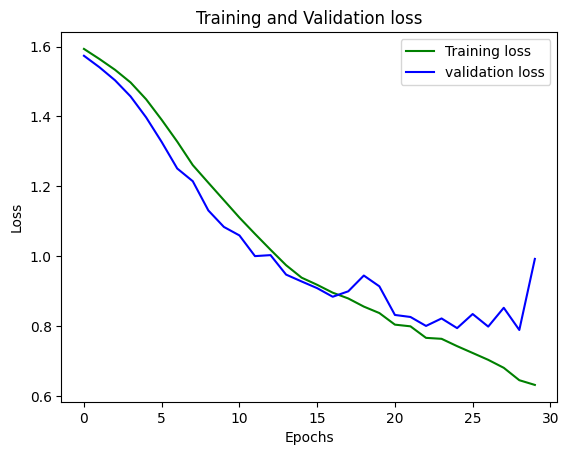

In [23]:
#Plot the graph of train_losses & valid_losses against nb_epochs.
epochs = range(nb_epochs)
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, valid_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
memload = pd.read_csv('memload.csv')

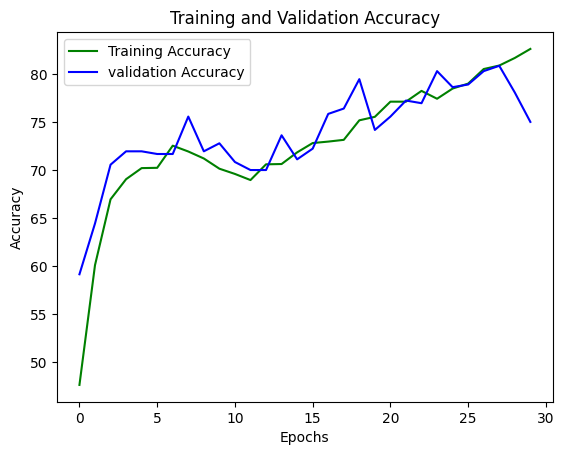

In [37]:
epochs = range(nb_epochs)
plt.plot(epochs, memload['Accuracy on Training set '], 'g', label='Training Accuracy')
plt.plot(epochs, memload['Accuracy on Validation set'], 'b', label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Testing the model

In [24]:
test_set = dataset(test_df,f'test_images',image_transform = image_transform,train = False )

In [25]:
test_dataloader = DataLoader(test_set, batch_size=32, shuffle=False) #DataLoader for test_set.

In [54]:
def test(dataloader,model):
    '''
    test function predicts the labels given an image batches.
    
    Args :
         dataloader: DataLoader for the test_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         
    Returns :
         List of predicted labels.
    '''
    
    model.eval() #Sets the model for evaluation.
    
    labels = [] #List to store the predicted labels.

    # images_list = []
    
    with torch.no_grad():
        
        for batch, (x,y) in enumerate(dataloader):
            
            # images_list.extend(x.cpu())
            
            output = model(x.to(device))
            
            predictions = output.argmax(dim=1).cpu().detach().tolist() #Predicted labels for an image batch.

            labels.extend(predictions)
                
    print('Testing has completed')
    # return list(zip(images_list, labels))        
    return labels
                

In [53]:
labels = test(test_dataloader,model) #Calls the test function.
# labels

Testing has completed


In [45]:
out_df = pd.DataFrame(labels)

In [46]:
out_df.to_csv('test_res.csv')

In [55]:
y_pred=test(valid_dataloader,model)

Testing has completed


In [60]:
y_act =  train_df.iloc[valid_set.indices]['diagnosis'].tolist()
# y_act

In [64]:
from sklearn.metrics import confusion_matrix 
cf = confusion_matrix(y_act, y_pred)
cf

array([[182,   0,   0,   0,   0],
       [ 16,  18,   3,   0,   1],
       [  8,  28,  57,   6,   0],
       [  2,   0,  12,   4,   1],
       [  0,   2,   9,   2,   9]], dtype=int64)

<AxesSubplot:>

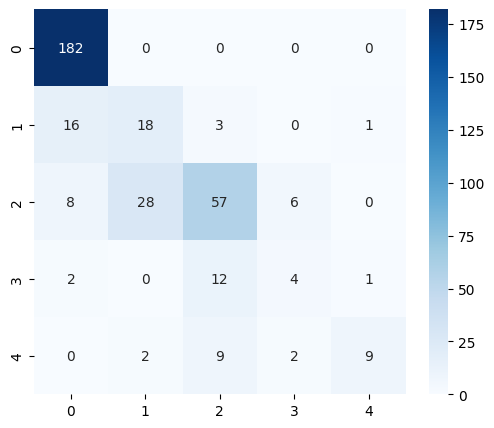

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
class_names = ["0", "1", "2","3", "4"]

# Plot confusion matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cf, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

In [62]:
from sklearn.metrics import classification_report 
print(classification_report(y_act, y_pred)) 

              precision    recall  f1-score   support

           0       0.88      1.00      0.93       182
           1       0.38      0.47      0.42        38
           2       0.70      0.58      0.63        99
           3       0.33      0.21      0.26        19
           4       0.82      0.41      0.55        22

    accuracy                           0.75       360
   macro avg       0.62      0.53      0.56       360
weighted avg       0.74      0.75      0.74       360



In [63]:
from sklearn.metrics import accuracy_score 
accuracy_score(y_act, y_pred) 

0.75

We can increase the accuracy of the model by various ways, like 

increasing the dataset size, 

increasing the model complexity, 

using ensemble models, and 

increasing the number of epochs.